In [2]:

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

In [3]:
for dirname, _, filenames in os.walk('./data'):
    print(dirname)

./data
./data\cell_images
./data\cell_images\Parasitized
./data\cell_images\Uninfected
./data\Parasitized
./data\Uninfected


In [4]:
def data_prep(parasitized, uninfected):
    
    parasitized = ["./data/Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected = ["./data/Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized) * ['parasitized'] + len(uninfected) * ['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [5]:
df = data_prep(os.listdir("./data/Parasitized/"), os.listdir("./data/Uninfected/"))

In [6]:
print("Shape of the DataFrame:", df.shape)
print("\nHead of the DataFrame:")
print(df.head())
print("\nTail of the DataFrame:")
print(df.tail())


Shape of the DataFrame: (27558, 2)

Head of the DataFrame:
                                          Image_Path       Labels
0  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
1  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
2  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
3  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
4  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized

Tail of the DataFrame:
                                              Image_Path      Labels
27553  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27554  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27555  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27556  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27557  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected


In [7]:
# Function to load and preprocess images
def load_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        images.append(img)
    return np.array(images)

# Load and preprocess images
# Assuming df is your DataFrame with 'Image_Path' and 'Labels' columns
# Make sure to replace df with your actual DataFrame variable
X = load_images(df['Image_Path'])
y = df['Labels']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build an improved CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, (y_train == 'parasitized').astype(int), epochs=30, batch_size=32, validation_split=0.2)
print(history)



Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.7532 - loss: 0.5657 - val_accuracy: 0.9404 - val_loss: 0.1618
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.9336 - loss: 0.2038 - val_accuracy: 0.9274 - val_loss: 0.2332
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.9464 - loss: 0.1697 - val_accuracy: 0.9551 - val_loss: 0.1460
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.9490 - loss: 0.1562 - val_accuracy: 0.9601 - val_loss: 0.1204
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.9542 - loss: 0.1361 - val_accuracy: 0.9578 - val_loss: 0.1542
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.9600 - loss: 0.1259 - val_accuracy: 0.9608 - val_loss: 0.1621
Epoch 7/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.9612 - loss: 0.1167 - val_accuracy: 0.9619 - val_loss: 0.1107
Epoch 8/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.9640 - loss: 0.1146 - 

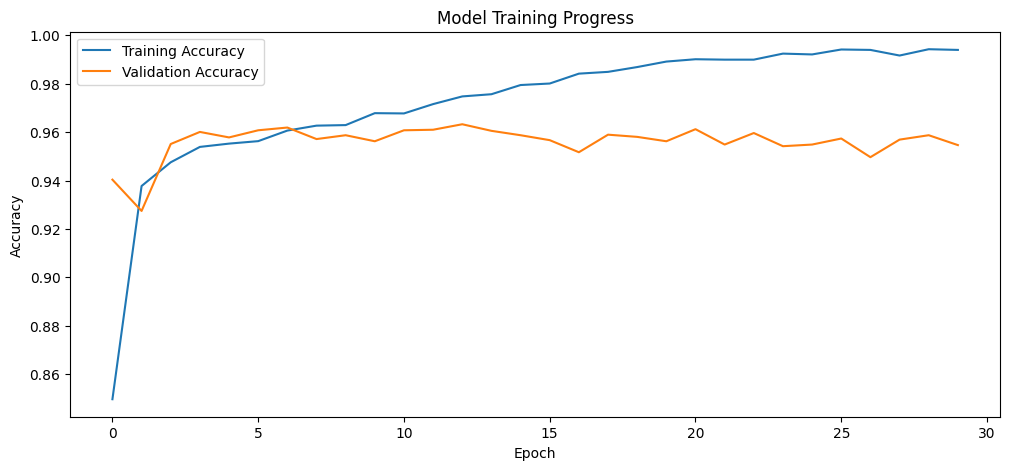

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
# Extract features from the CNN model
import joblib
cnn_features_train = model.predict(X_train)
cnn_features_test = model.predict(X_test)

# Reshape features for Random Forest
cnn_features_train = cnn_features_train.reshape(
    cnn_features_train.shape[0], -1)
cnn_features_test = cnn_features_test.reshape(cnn_features_test.shape[0], -1)



689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
# Build a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(cnn_features_train, (y_train == 'parasitized'))

# Predict using the hybrid model (Random Forest)
rf_predictions = rf_model.predict(cnn_features_test)
y_pred = rf_model.predict(cnn_features_test)

# Evaluate the hybrid model
accuracy = accuracy_score((y_test == 'parasitized'), rf_predictions)
print()
print(f"Accuracy of the hybrid model: {accuracy*100}")


# Calculate evaluation metrics
accuracy = accuracy_score((y_test == 'parasitized'), y_pred)
f1 = f1_score((y_test == 'parasitized'), y_pred)
precision = precision_score((y_test == 'parasitized'), y_pred)
conf_matrix = confusion_matrix((y_test == 'parasitized'), y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Specificity:", specificity)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy of the hybrid model: 95.22859216255442
Accuracy: 0.9522859216255443
F1 Score: 0.952604072805911
Precision: 0.9603924418604651
Specificity: 0.959852670349908
Confusion Matrix:
[[2606  109]
 [ 154 2643]]


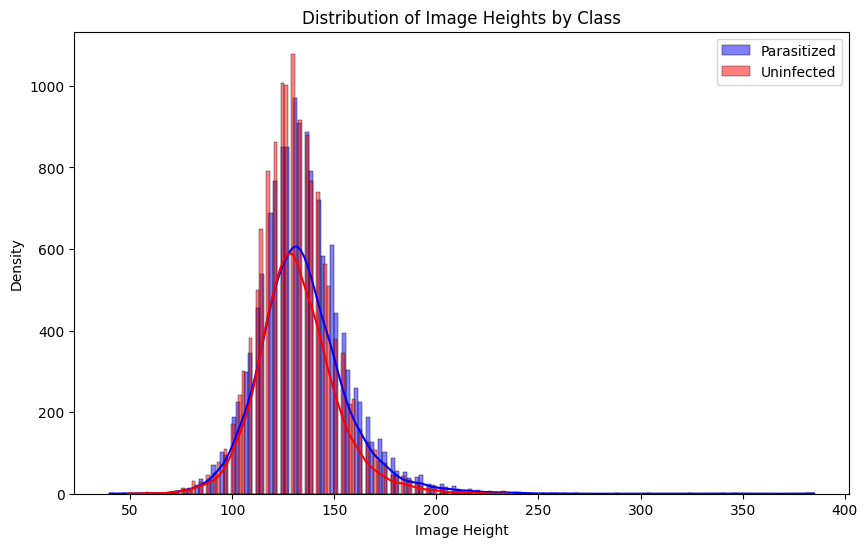

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Labels'] == 'parasitized']['Image_Path'].apply(
    lambda x: cv2.imread(x).shape[0]), color='blue', label='Parasitized', kde=True)
sns.histplot(df[df['Labels'] == 'uninfected']['Image_Path'].apply(
    lambda x: cv2.imread(x).shape[0]), color='red', label='Uninfected', kde=True)
plt.title('Distribution of Image Heights by Class')
plt.xlabel('Image Height')
plt.ylabel('Density')
plt.legend()
plt.show()


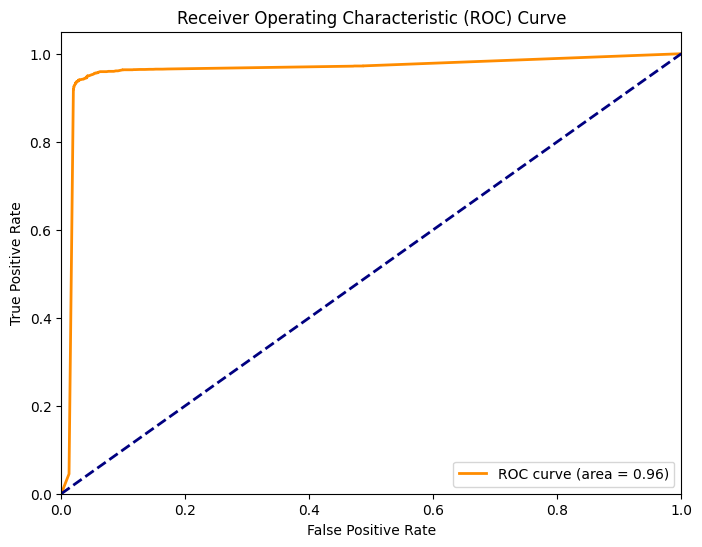

In [24]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(
    (y_test == 'parasitized'), rf_model.predict_proba(cnn_features_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


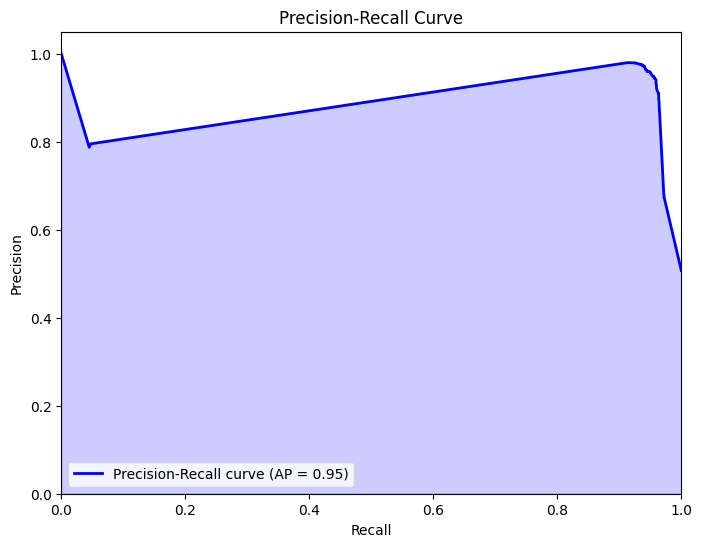

In [25]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(
    (y_test == 'parasitized'), rf_model.predict_proba(cnn_features_test)[:, 1])
average_precision = average_precision_score(
    (y_test == 'parasitized'), rf_model.predict_proba(cnn_features_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
